In [2]:
import requests, zipfile, io

url = "https://academy.hackthebox.com/storage/modules/292/KDD_dataset.zip"

response = requests.get(url)
z = zipfile.ZipFile(io.BytesIO(response.content))
z.extractall('.')

In [5]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import seaborn as sns 
import matplotlib.pyplot as plt

# Set the file path to the dataset
file_path = r'KDD+.txt'

# Define the column names corresponding to the NSL-KDD dataset
columns = [
    'duration', 'protocol_type', 'service', 'flag', 'src_bytes', 'dst_bytes', 
    'land', 'wrong_fragment', 'urgent', 'hot', 'num_failed_logins', 'logged_in', 
    'num_compromised', 'root_shell', 'su_attempted', 'num_root', 'num_file_creations', 
    'num_shells', 'num_access_files', 'num_outbound_cmds', 'is_host_login', 'is_guest_login', 
    'count', 'srv_count', 'serror_rate', 'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate', 
    'same_srv_rate', 'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count', 'dst_host_srv_count', 
    'dst_host_same_srv_rate', 'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate', 
    'dst_host_srv_diff_host_rate', 'dst_host_serror_rate', 'dst_host_srv_serror_rate', 
    'dst_host_rerror_rate', 'dst_host_srv_rerror_rate', 'attack', 'level'
]

#read the combined NSL-KDD dataset into a DataFrame
df = pd.read_csv(file_path, names=columns)

print(df.head())

   duration protocol_type   service flag  src_bytes  dst_bytes  land  \
0         0           tcp  ftp_data   SF        491          0     0   
1         0           udp     other   SF        146          0     0   
2         0           tcp   private   S0          0          0     0   
3         0           tcp      http   SF        232       8153     0   
4         0           tcp      http   SF        199        420     0   

   wrong_fragment  urgent  hot  ...  dst_host_same_srv_rate  \
0               0       0    0  ...                    0.17   
1               0       0    0  ...                    0.00   
2               0       0    0  ...                    0.10   
3               0       0    0  ...                    1.00   
4               0       0    0  ...                    1.00   

   dst_host_diff_srv_rate  dst_host_same_src_port_rate  \
0                    0.03                         0.17   
1                    0.60                         0.88   
2             

In [6]:
#Binary classification of target
#Maps normal traffic to 0 and any type of attack to 1
df['attack_flag'] = df['attack'].apply(lambda a: 0 if a == 'normal' else 1)

In [7]:
#Multiclass classification for different types of attacks
dos_attacks = ['apache2', 'back', 'land', 'neptune', 'mailbomb', 'pod', 
               'processtable', 'smurf', 'teardrop', 'udpstorm', 'worm']
probe_attacks = ['ipsweep', 'mscan', 'nmap', 'portsweep', 'saint', 'satan']
privilege_attacks = ['buffer_overflow', 'loadmdoule', 'perl', 'ps', 
                     'rootkit', 'sqlattack', 'xterm']
access_attacks = ['ftp_write', 'guess_passwd', 'http_tunnel', 'imap', 
                  'multihop', 'named', 'phf', 'sendmail', 'snmpgetattack', 
                  'snmpguess', 'spy', 'warezclient', 'warezmaster', 
                  'xclock', 'xsnoop']

def map_attack(attack):
    if attack in dos_attacks:
        return 1
    elif attack in probe_attacks:
        return 2
    elif attack in privilege_attacks:
        return 3
    elif attack in access_attacks:
        return 4
    else:
        return 0

#Assign multi-class categories to each row 
df['attack_map'] = df['attack'].apply(map_attack)

In [8]:
features_to_encode = ['protocol_type', 'service']
encoded = pd.get_dummies(df[features_to_encode])

In [9]:
# Numeric features that capture various statistical properties of the traffic
numeric_features = [
    'duration', 'src_bytes', 'dst_bytes', 'wrong_fragment', 'urgent', 'hot', 
    'num_failed_logins', 'num_compromised', 'root_shell', 'su_attempted', 
    'num_root', 'num_file_creations', 'num_shells', 'num_access_files', 
    'num_outbound_cmds', 'count', 'srv_count', 'serror_rate', 
    'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate', 'same_srv_rate', 
    'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count', 'dst_host_srv_count', 
    'dst_host_same_srv_rate', 'dst_host_diff_srv_rate', 
    'dst_host_same_src_port_rate', 'dst_host_srv_diff_host_rate', 
    'dst_host_serror_rate', 'dst_host_srv_serror_rate', 'dst_host_rerror_rate', 
    'dst_host_srv_rerror_rate'
]

#combine encoded categorical variables and numeric features
train_set = encoded.join(df[numeric_features])

#Multi class target variable 
multi_y = df['attack_map']

In [10]:
#split data into training and test sets for multi-class classification. Assign 20% of the data set for testing and 80%for training
train_X, test_X, train_y, test_y = train_test_split(train_set, multi_y, test_size=0.2, random_state=1337)

#Further split into training and validation sets 
multi_train_X, multi_valid_X, multi_train_y, multi_valid_y =train_test_split(train_X, train_y, test_size=0.3, random_state=1337)

In [11]:
#Train randomforest model for multi-class classification
rf_model_multi = RandomForestClassifier(random_state=1337)
rf_model_multi.fit(multi_train_X, multi_train_y)

RandomForestClassifier(random_state=1337)

Validation Set Evaluation:
Accuracy: 0.9950
Precision: 0.9949
Recall: 0.9950
F1-Score: 0.9949


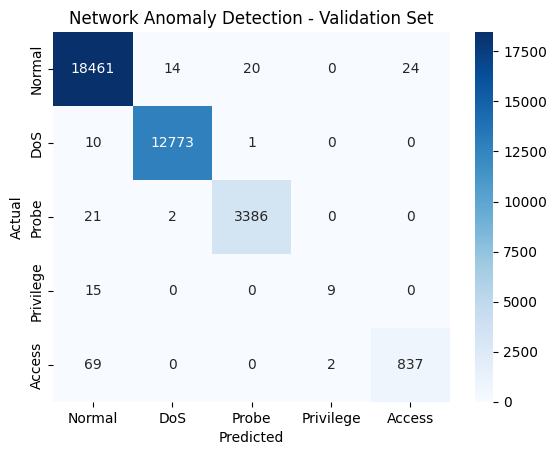

Classification Report for Validation Set:
              precision    recall  f1-score   support

      Normal       0.99      1.00      1.00     18519
         DoS       1.00      1.00      1.00     12784
       Probe       0.99      0.99      0.99      3409
   Privilege       0.82      0.38      0.51        24
      Access       0.97      0.92      0.95       908

    accuracy                           1.00     35644
   macro avg       0.96      0.86      0.89     35644
weighted avg       0.99      1.00      0.99     35644



In [12]:
#Predict and evaluate the model on the validation set 
multi_predictions = rf_model_multi.predict(multi_valid_X)
accuracy = accuracy_score(multi_valid_y, multi_predictions)
precision = precision_score(multi_valid_y, multi_predictions, average='weighted')
recall = recall_score(multi_valid_y, multi_predictions, average='weighted')
f1 = f1_score(multi_valid_y, multi_predictions, average='weighted')

print(f"Validation Set Evaluation:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

#Confusion matrix for validation set 
conf_matrix = confusion_matrix(multi_valid_y, multi_predictions)
class_labels = ['Normal', 'DoS', 'Probe', 'Privilege', 'Access']
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_labels,
            yticklabels=class_labels)
plt.title('Network Anomaly Detection - Validation Set')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

#Classification report for Validation Set 
print("Classification Report for Validation Set:")
print(classification_report(multi_valid_y, multi_predictions, target_names=class_labels))


Test Set Evaluation:
Accuracy: 0.9949
Precision: 0.9947
Recall: 0.9949
F1-Score: 0.9947


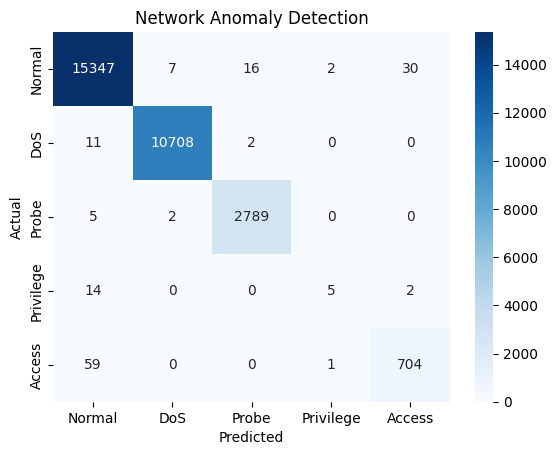

Classification Report for Test Set:
              precision    recall  f1-score   support

      Normal       0.99      1.00      1.00     15402
         DoS       1.00      1.00      1.00     10721
       Probe       0.99      1.00      1.00      2796
   Privilege       0.62      0.24      0.34        21
      Access       0.96      0.92      0.94       764

    accuracy                           0.99     29704
   macro avg       0.91      0.83      0.85     29704
weighted avg       0.99      0.99      0.99     29704



In [13]:
#Final evaluation on the test set
test_multi_predictions = rf_model_multi.predict(test_X)
test_accuracy = accuracy_score(test_y, test_multi_predictions)
test_precision = precision_score(test_y, test_multi_predictions, average='weighted')
test_recall = recall_score(test_y, test_multi_predictions, average='weighted')
test_f1 = f1_score(test_y, test_multi_predictions, average ='weighted')

print("\nTest Set Evaluation:")
print(f"Accuracy: {test_accuracy:.4f}")
print(f"Precision: {test_precision:.4f}")
print(f"Recall: {test_recall:.4f}")
print(f"F1-Score: {test_f1:.4f}")

#Confusion matrix for test set
test_conf_matrix = confusion_matrix(test_y, test_multi_predictions)
sns.heatmap(test_conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_labels,
            yticklabels=class_labels)
plt.title('Network Anomaly Detection')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Classification Report for Test Set
print("Classification Report for Test Set:")
print(classification_report(test_y, test_multi_predictions, target_names=class_labels))

In [14]:
import joblib

# Save the trained model to a file
model_filename = 'network_anomaly_detection_model.joblib'
joblib.dump(rf_model_multi, model_filename)

print(f"Model saved to {model_filename}")

Model saved to network_anomaly_detection_model.joblib
